Created August 17, 2023

Purpose is to update location grid search in the following ways:
1. use templates whose constituent waveforms were normalized before stacking (fixes most false features)
2. use elep to find picktimes instead of envelope cross correlation
3. base velocity model of grid search on p and s picktimes when possible
4. compare locations to ComCat potential matches from the <a href="https://assets.pnsn.org/red/">redpy website</a> when possible

last updated October 30, 2023

In [1]:
import requests
import h5py
import yaml
import csv
import eqcorrscan
from eqcorrscan import Tribe
from time import time
import obspy
from obspy import UTCDateTime, Trace
import pandas as pd
from glob import glob
import numpy as np
from obspy.signal.cross_correlation import *
import matplotlib.pyplot as plt
from geopy import distance
from tqdm import trange

import torch
plt.rcParams.update({'font.size': 10})
# from utils import *


import seisbench.models as sbm
device = torch.device("cpu")

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from mbf_elep_func import apply_mbf
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func
from ELEP.elep.trigger_func import picks_summary_simple

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

Matched-filter CPU is not compiled! Should be here: /home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/fast_matched_filter/lib/matched_filter_CPU.so


In [2]:
#read config file for parameters
with open('/home/smocz/expand_redpy/scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

smooth_length = config['smooth_length']
fs = config['fs']
tb = config['tb']
ta = config['ta']
fqmin = config['fqmin']
fqmax = config['fqmax']
chan = config['chan']
homedir = config['homedir']
readdir = config['readdir']
minsta = config['minsta']
grid_length = float(config['grid_length'])
grid_height = float(config['grid_height'])
step = config['step']
t_step = config['t_step']
vs_min = config['vs_min']
vs_max = config['vs_max']
vs_step = config['vs_step']
volc_lat_lon = config['volc_lat_lon']
volc_list_names = config['volc_list_names']

vv = config['vv']

istart = config['nlta']*fs
print(istart)


print(volc_list_names[vv])



400.0
Hood


In [3]:
volc_md = pd.read_csv(readdir+'Volcano_Metadata.csv')
#associate network and station
volc_md['netsta'] = volc_md['Network'].astype(str)+'.'+volc_md['Station'].astype(str)

In [4]:
#color map for plotting
def get_cmap(n, name='viridis'): #hsv
#     Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     RGB color; the keyword argument name must be a standard mpl colormap name.
    return plt.cm.get_cmap(name, n)

# define function to predict synthetic arrival times
def travel_time(t0, x, y, vs, sta_x, sta_y):
    dist = np.sqrt((sta_x - x)**2 + (sta_y - y)**2)
    tt = t0 + dist/vs
    return tt

# define function to compute residual sum of squares
def error(synth_arrivals,arrivals):
    res = arrivals - synth_arrivals   #make sure arrivals are in the right order, maybe iterate through keys
    res_sqr = res**2
    rss = np.sum(res_sqr)
    return rss

# define function to iterate through grid and calculate travel time residuals
def gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals):
    rss_mat = np.zeros((len(t0),len(x_vect),len(y_vect)))
    rss_mat[:,:,:] = np.nan
    for i in range(len(t0)): 
        for j in range(len(x_vect)):
            for k in range(len(y_vect)):
                for m in range(len(vs)): #parameterize velocity
                    synth_arrivals = []
                    for h in range(len(sta_x)):
                        tt = travel_time(t0[i],x_vect[j],y_vect[k],vs[m],sta_x[h],sta_y[h]) 
                    #add vs in nested loop, vector 1000-5000, per cluster to account for p and s waves
                        synth_arrivals.append(tt)
                    rss = error(np.array(synth_arrivals),np.array(arrivals))
                    rss_mat[i,j,k] = rss
    return rss_mat

# define function to convert the location index into latitude and longitude
def location(x_dist, y_dist, start_lat, start_lon):
    bearing = 90-np.rad2deg(np.arctan(y_dist/x_dist))
    dist = np.sqrt((x_dist)**2 + (y_dist)**2)
    d = distance.geodesic(meters = dist)
    loc_lat = d.destination(point=[start_lat,start_lon], bearing=bearing)[0]
    loc_lon = d.destination(point=[start_lat,start_lon], bearing=bearing)[1]
    return loc_lat, loc_lon, d

# define function to find diameter in meters of the error on the location
def error_diameter(new_array):
    min_idx = np.min(new_array[:,1])
    max_idx = np.max(new_array[:,1])
    difference = max_idx-min_idx
    diameter_m = difference*1000
    return diameter_m 

#get clusterid from template name
def getcl_id(t_name_str): #for normalized
    t_cl = int(t_name_str.split('_')[-1])
    return t_cl

In [5]:
# ML picker parameters
paras_semblance = {'dt':0.025, 'semblance_order':4, 'window_flag':True, 
                   'semblance_win':0.5, 'weight_flag':'max'}
p_thrd, s_thrd = 0.01, 0.05

# download models
pretrain_list = ["pnw","ethz","instance","scedc","stead","geofon","neic"]
pn_pnw_model = sbm.EQTransformer.from_pretrained('pnw')
pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")

#list of models to run through
list_models = [pn_pnw_model,pn_ethz_model,pn_scedc_model,pn_neic_model,pn_geofon_model,pn_stead_model,pn_instance_model]

pn_pnw_model.to(device); #imodel 0
pn_ethz_model.to(device); #imodel 1
pn_scedc_model.to(device); #imodel 2
pn_neic_model.to(device); #imodel 3
pn_geofon_model.to(device); #imodel 4
pn_stead_model.to(device); #imodel 5
pn_instance_model.to(device); #imodel 6

Find picktimes

In [6]:
#pull in h5 for volcano

all_temps = []
all_waves = []

for filepath in glob(f'/home/smocz/expand_redpy_new_files/h5/normalized_{volc_list_names[vv].lower()}_templates_*.h5'):
    net = filepath.split('_')[-2]
    with h5py.File(filepath, "r") as f: #pull in fingerprints
        template_name = f["template_name"][()]
        waveforms = f["waveforms"][()]
#         print(f.keys()) #print what data is in this file
    [all_temps.append(i) for i in template_name]
    [all_waves.append(i) for i in waveforms]
    
all_waves = np.array(all_waves)
all_temps = [str(i)[2:-1] for i in all_temps]

In [7]:
#get some info
v = volc_md[volc_md['Volcano_Name'] == volc_list_names[vv]]['netsta'].values.tolist() #list of network and station per volc
clid = np.unique([getcl_id(i) for i in all_temps]) #list of cluster ids
cllen = len(str(max(clid))) #length of the largest cluster ID, used for zfill
zz = chan[-2:].lower() #the last two letters of channel names (essentially the letters in chan)
csv_name = f'{homedir}locations/{volc_list_names[vv]}_ELEP_normalized_picktimes_TESTING_REWORK.csv' #name of the csv for picktimes at this volcano

In [20]:
# create csv for volcano
# with open(csv_name, 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Network','Station','Cluster_ID','Template_Name','SMB_peak']) #,'SMB_peak_MBF'
#     file.close()

Finding picktimes for each station at cluster 13:  12%|█▎        | 2/16 [01:13<08:31, 36.51s/it]

<class 'int'>


Finding picktimes for each station at cluster 13:  31%|███▏      | 5/16 [02:25<05:09, 28.17s/it]

<class 'int'>


Finding picktimes for each station at cluster 13:  38%|███▊      | 6/16 [03:38<06:31, 39.13s/it]

<class 'int'>


Finding picktimes for each station at cluster 13:  56%|█████▋    | 9/16 [04:51<03:40, 31.52s/it]

<class 'int'>


Finding picktimes for each station at cluster 13:  62%|██████▎   | 10/16 [06:04<03:57, 39.62s/it]

<class 'int'>


Finding picktimes for each station at cluster 13:  69%|██████▉   | 11/16 [07:17<03:54, 46.88s/it]

<class 'int'>


Finding picktimes for each station at cluster 13:  81%|████████▏ | 13/16 [08:30<02:08, 42.86s/it]

<class 'int'>


Finding picktimes for each station at cluster 13: 100%|██████████| 16/16 [09:42<00:00, 36.43s/it]

<class 'int'>


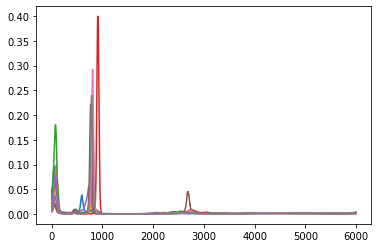

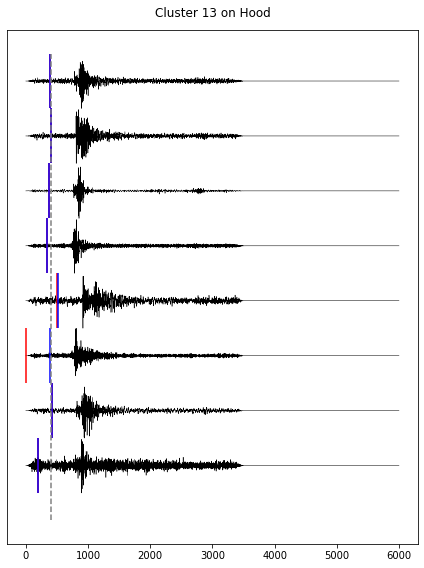

In [8]:
### PULL IN TEMPLATES ###
# cl_trange = trange(max(clid), desc="Finding picktimes for each cluster", leave=True)
cl_trange=range(13,max(clid))
for cl in cl_trange:
#     print('------') #print a divider
#     print("cluster:",str(cl).zfill(cllen)) #print the cluster ID
    
    temps_w = [] #list of templates waveforms for this cluster
    temps_n = [] #list of template names
    temps_p = [] #list of template picks (list of arrays)
    
    stopwatch0=time() #note the time
    
    s_trange = trange(len(v), desc=f"Finding picktimes for each station at cluster {cl}", leave=True) #has a progress bar
#     s_trange = range(0,len(v)) #no progress bar
    for s in s_trange: #loop through stations that have a template for this cluster
        net, sta =  v[s].split('.') #add specific network per station
        
        for tt,t in enumerate(all_temps): #go through each template
            if t.split('_')[0]==net and t.split('_')[1]==sta and t.split('_')[-1]==str(cl): #if the template is for this station and cluster
                
                ### PREPARE DATA ###
#                 Trace(all_waves[tt]).plot(); #show before preparation
                wave = all_waves[tt].copy() #create copy
                
                t_tapered = Trace(wave).taper(0.05) #make waveform a trace to taper it
                padded_wave = np.hstack((t_tapered.data[:],np.zeros(2480))) #take data from tapered trace and pad end 
                #with zeros so that len(t_trace)=6000 and will fit in the nueral network
                t_trace = Trace(padded_wave,{'sampling_rate':fs}) #make back into a Trace, and set sampling rate
#                 print(len(t_trace))
                
                temps_w.append(t_trace) #append trace
                temps_n.append(t) #append name
                
#                 t_trace.plot(); #plot trace after preparation

    
                ### FIND PICKS! ###

                #picking params
                evt_data = Stream(traces=[t_trace])
                sta_available = [sta]
                list_models = list_models
                twin = len(t_trace)-1


                dt = 1/fs; fs = fs
                nfqs = 5
                nt = 6000; nc = 3
                istart = istart
                iend = len(wave)-1
                fq_list = make_LogFq(fqmin, fqmax, dt, nfqs)
                coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt)
                MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
                    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc, 'npoles': 2}

                paras_semblance = {'dt':dt, 'semblance_order':2, 'window_flag':True, 
                                   'semblance_win':0.5, 'weight_flag':'max'}
                
                #find picktimes!
                smb_peak,smb_peak_mbf,peaks = apply_mbf(evt_data, sta_available, \
                list_models, MBF_paras, paras_semblance, istart, iend)
                
                temps_p.append([smb_peak[0], smb_peak_mbf[0], peaks])
        
                #append picks to csv
#                 row = [net, sta, cl, t, smb_peak[0], smb_peak_mbf[0]]
#                 with open(csv_name, 'a', newline='') as file:
#                     writer = csv.writer(file)
#                     writer.writerow(row)
#                     file.close()
    ### PLOT ###
    height = len(temps_w)
    fig, ax0 = plt.subplots(figsize=(6,height))

    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(temps_w):
        ax0.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        plt.vlines(x=temps_p[ww][0]*fs,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='red')
        plt.vlines(x=temps_p[ww][1]*fs,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='blue')
    plt.vlines(x=10*fs,ymin=0,ymax=(yscale+(yscale*ww))+(0.5*yscale),color='gray',linestyle='dashed')
    #RED is smb
    #BLUE is mbf
    #GRAY is the 10 second mark/end noise window for SNR

    ax0.tick_params(axis='y', which='both',left=False,labelleft=False)
    

    fig.suptitle(f'Cluster {cl} on {volc_list_names[vv]}')
    fig.set_tight_layout(True)
    plt.show()
    plt.close()
    break

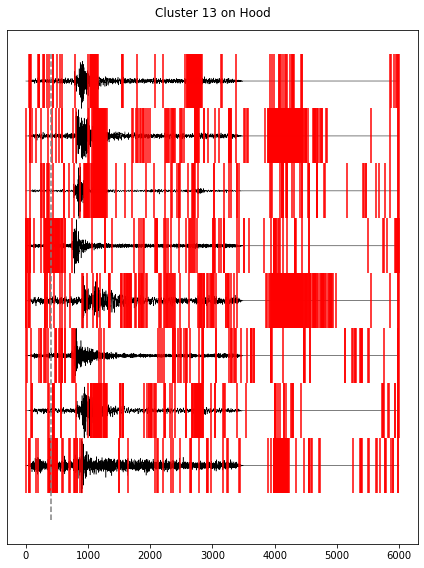

In [17]:
height = len(temps_w)
fig, ax0 = plt.subplots(figsize=(6,height))

yscale = 2 #how far to space waveforms from eachother
wavecolor = 'black'
for ww, wave in enumerate(temps_w):
    ax0.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
    for i in temps_p[ww][2][0]:
        plt.vlines(x=i,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='red')
plt.vlines(x=10*fs,ymin=0,ymax=(yscale+(yscale*ww))+(0.5*yscale),color='gray',linestyle='dashed')
#RED is smb
#BLUE is mbf
#GRAY is the 10 second mark/end noise window for SNR

ax0.tick_params(axis='y', which='both',left=False,labelleft=False)


fig.suptitle(f'Cluster {cl} on {volc_list_names[vv]}')
fig.set_tight_layout(True)
plt.show()
plt.close()

In [16]:
print(temps_p[ww][2][0])

10


In [ ]:
plt.plot(t_trace.data[:6000])


### Plotting times as vlines on templates

In [12]:
#pull in csv with picktimes
picktimes_df = pd.read_csv(csv_name)
picktimes_df.head()

,Network,Station,Cluster_ID,Template_Name,SMB_peak,SMB_peak_MBF
0,UW,HOOD,0,UW_HOOD_rpho_0,17.725,17.775
1,UW,TDH,0,UW_TDH_rpho_0,17.125,17.225
2,UW,VFP,0,UW_VFP_rpho_0,19.950,19.975
3,UW,VLL,0,UW_VLL_rpho_0,19.625,19.650
4,CC,HIYU,1,CC_HIYU_rpho_1,18.350,18.450


In [ ]:
#loop to plot each template, and each picktime as a vline
#one plot per redpy cluster

### PULL IN TEMPLATES ###
# cl_trange = trange(max(clid), desc="Finding picktimes for each cluster", leave=True)
for cl in range(0,max(clid)):
#     print('------') #print a divider
#     print("cluster:",str(cl).zfill(cllen)) #print the cluster ID
    
    temps_w = [] #list of templates waveforms for this cluster
    temps_n = [] #list of template names
    temps_p = [] #list of template picks (list of lists)
    
    stopwatch0=time() #note the time
    
#     s_trange = trange(len(v), desc=f"Finding picktimes for each station at cluster {cl}", leave=True)
    for s in range(0,len(v)): #loop through stations that have a template for this cluster
        net, sta =  v[s].split('.') #add specific network per station
        
        for tt,t in enumerate(all_temps): #go through each template
            if t.split('_')[0]==net and t.split('_')[1]==sta and t.split('_')[-1]==str(cl): #if the template is for this station and cluster
                
                ### PREPARE DATA ###
                wave = Trace(all_waves[tt]).copy() #create copy
                temps_w.append(wave)
                temps_n.append(t)
                
                #pull picktimes from csv
                smb = picktimes_df[picktimes_df['Template_Name']==t]['SMB_peak'].values.tolist()[0]
                mbf = picktimes_df[picktimes_df['Template_Name']==t]['SMB_peak_MBF'].values.tolist()[0]
                
                temps_p.append([smb,mbf])
    
    #plot for cluster
    
    height = len(temps_w)
    fig, ax0 = plt.subplots(figsize=(6,height))

    yscale = 2 #how far to space waveforms from eachother
    wavecolor = 'black'
    for ww, wave in enumerate(temps_w):
        ax0.plot(wave.data[:]/np.max(np.abs(wave.data))+yscale+(yscale*ww),color=wavecolor,linewidth=.5)
        plt.vlines(x=temps_p[ww][0]*fs,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='red')
        plt.vlines(x=temps_p[ww][1]*fs,ymin=(yscale+(yscale*ww))-(0.5*yscale),ymax=(yscale+(yscale*ww))+(0.5*yscale),color='blue')
    plt.vlines(x=10*fs,ymin=0,ymax=(yscale+(yscale*ww))+(0.5*yscale),color='gray',linestyle='dashed')
    #RED is smb
    #BLUE is mbf
    #GRAY is the 10 second mark/end noise window for SNR

    ax0.tick_params(axis='y', which='both',left=False,labelleft=False)
    

    fig.suptitle(f'Cluster {cl} on {volc_list_names[vv]}')
    fig.set_tight_layout(True)
    plt.show()
    plt.close()
#     break


In [ ]:
#run code normally (exclude mbf to speed it up)
#for clusters that do not start before 10s, redo the picktime (istart=10)
#when finding location, exclude outliers (outside expected phase shift)

---

### Old code

In [ ]:
array0 = np.array([0,0,0,3,4,5,6])
array1 = np.zeros(6)
print(np.hstack((array0,array1)))

In [ ]:
print(len(Trace(all_waves[tt],{'sampling_rate':40}))/40)

In [ ]:
v = volc_sta[vv] 
clid = np.unique([getcl_id(i) for i in all_temps]) #list of cluster ids
cllen = len(max(clid)) #length of the largest cluster ID, used for zfill
zz = chan[-2:].lower() #the last two letters of channel names (essentially the letters in chan)
#make csv?



for cl in range(0,max(clid)):#options: cl in range(0,clid[-1]+1) for specific ranges; cl in clid for all Cluster IDs
    temps_s = {} #empty dictionary that will be filled with the templates for this cluster
    print('------') #print a divider
    print("cluster:",str(cl).zfill(cllen)) #print the cluster ID
    stopwatch0=time() #note the time
    for s in range(0,len(v)): #loop through stations
        net, sta =  v[s].split('.') #add specific network per station

########################################################################    
#                       FINDING PICK TIMES                             #
########################################################################

        # try to read the h5 file
        try:
            T = Tribe().read(*glob(f'{homedir}templates/Volcano_{volc_list_names[vv]}_Network_{net}_Station_{sta}_Channel_*.tgz'))
        except:
            print(f'{net}.{sta} tgz does not exist')
            continue
        for t in T: #for each template in the tgz
            if t.name.endswith(str(cl).zfill(cllen)): #if the template name endswith this cluster
                temps_s[f'{net.lower()}.{t.name}']=t #save to dictionary and include network name
                break

    if len(temps_s) < minsta: #if the number of templates for this cluster is less than minsta (see config)
        print('not enough stations with data for this cluster') #print a reminder
        stopwatch2=time() #note the time
        print(f'{stopwatch2-stopwatch0} s for this cluster') #say how many s to go through this cluster
        continue #move onto the next cluster
        
    data_env_dict = {} #a dictionary of the envelopes for each template stream
    for t in temps_s: #for each saved template (aka each template for this cluster and volc that exists)
        data_envelope = obspy.signal.filter.envelope(temps_s[t].st[0].data) #make an envelope
        data_envelope /= np.max(data_envelope) #average envelope (?)
        data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length) #smooth the envelope
        data_env_dict[t] = data_envelope #save the envelope to the dictionary

    pick_times = {} #dictionary of picktimes for each template
    for key in data_env_dict: #for each envelope
        p, shift, relative_p = pick_time(ref_env=data_env_dict[list(data_env_dict.keys())[0]], 
                data_env_dict=data_env_dict[key],st=temps_s[key].st) #calculate picktimes
        pick_times[key] = relative_p #save to dictionary
    print(f'{cl} offsets are {pick_times}') #print pick times relative to first template stream (can be negative)
    
    #arranging picktimes from 0 (earliest station) to later (positive) times
    #will NOT be used for plotting picktimes, but will be used for location
    dif_dict = {} #dictionary of picktimes in reference to earliest picktime (in positive seconds after the earliest picktime)
    max_value = max(pick_times, key=pick_times.get) #get key for max value of pick_times aka the earliest picktime
    for key in pick_times: #for each picktime
        dif = round(abs(pick_times[max_value] - pick_times[key]),4) #max value minus current value
        dif_dict[key] = dif #save to dictionary with the same key as pick_times

    
########################################################################    
#                       PLOTTING PICK TIMES                            #
########################################################################

#     cmap = get_cmap(len(temps_s)) #get cmap aka colors for the plot, see def(get_cmap) for color palette
#     plt.figure(figsize=(10,10)) #set plot size
#     plt.title('aligned templates, vlines are template starts') #plot title
#     for tt,t in enumerate(temps_s): #for every template
#         shift = round(pick_times[t]*fs) #find shift based on picktimes
#         st0 = temps_s[t].st.copy() #make a copy for a reference
#         maxdata = len(temps_s[t].st[0].data[:]) #find maximum length of template stream

#         empty = Trace(np.zeros(shift)) #an empty trace/a trace filled with zeros
#         if shift<0: #if shift is negative
#             temps_s[t].st[0].data[:shift]=st0[0].data[-shift:] #shift to the left
#         if shift>0: #if shift is positive
#             temps_s[t].st[0].data[shift:]=st0[0].data[:-shift] #shift to the right
#             temps_s[t].st[0].data[:shift]=empty.data[:shift] #get rid of leftover data from shift
#         #note: if shift == 0, will be plotting with no shifting
#         plt.plot(temps_s[t].st[0].data[:]/np.max(np.abs(temps_s[t].st[0].data[:]))+2*tt,color=cmap(tt), label=t) #plot stream
#         plt.vlines(shift,ymin=-1,ymax=2*len(temps_s),color=cmap(tt)) #plot line in same color representing the start of the template
#         plt.legend() #show the legend
    
#     first_sta = max(pick_times, key=pick_times.get) #gives you the template name for the first
    #station to get a signal (largest/most positive pick time)
    
########################################################################    
#                         FINDING LOCATION                             #
########################################################################

    # define input parameters
    arrivals = [] #relative picktimes, dif_dict as a list
    sta_lats = [] #station latitudes, from metadata
    sta_lons = [] #station longitudes, from metadata
    netsta_names = [] #list of station names with networks
    for key in dif_dict: #for each station
        arrivals.append(dif_dict[key]) #append pick time to arrivals
        
        #finding station name
        if not key.endswith(str(cl).zfill(cllen)): #if the wrong cluster id
            print('template name does not match cluster ID') #print an error
            continue #and skip the rest
        if key.endswith(f'{zz}rp{volc_list_names[vv][:2].lower()}{str(cl).zfill(cllen)}'): #if the key has a channel name in it (the 'hz')
            md_netsta = key[:-(7+cllen)] #remember the stuff before channel name rpvo and cluster ID
        if not key.endswith(f'{zz}rp{volc_list_names[vv][:2].lower()}{str(cl).zfill(cllen)}'): #if the key has NO channel name in it
            md_netsta = key[:-(4+cllen)] #remember the stuff before rpvo and cluster ID
#         print(md_netsta)
        lat = volc_md[volc_md['netsta']==md_netsta.upper()]['Latitude'].values.tolist() #get latitude from metadata
        sta_lats.append(lat[0]) #append
        
        lon = volc_md[volc_md['netsta']==md_netsta.upper()]['Longitude'].values.tolist() #get longitude form metadata
        sta_lons.append(lon[0]) #append
        
        netsta_names.append(md_netsta.upper()) # make list of station names


    # define grid origin in lat,lon
    
    #finding bottom left corner of grid map
    lat_start = volc_lat_lon[volc_list_names[vv]][0] - (grid_length/222000) #volcano lat minus half of grid length in decimal lat long
    lon_start = volc_lat_lon[volc_list_names[vv]][1] - (grid_height/222000) #volcano long minus half of grid height in decimal lat long
        
    #station lat lons to x y
    sta_x = []
    sta_y = []
    for i in range(len(sta_lats)):
        x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
        y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
        sta_x.append(x_dist)
        sta_y.append(y_dist)

    # set grid points
    x_vect = np.arange(0, grid_length, step)
    y_vect = np.arange(0, grid_height, step)
    t0 = np.arange(0,np.max(arrivals),t_step)
    vs = np.arange(vs_min,vs_max,vs_step)

    print('yo')
    # carry out the gridsearch
    rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals)
    print('here')
    # find lowest error lat, lon, and origin time
    loc_idx = np.unravel_index([np.argmin(rss_mat)], rss_mat.shape)
    
    # find the lat and lon of the location index
    loc_lat, loc_lon, d = location(x_vect[loc_idx[1]], y_vect[loc_idx[2]], lat_start, lon_start)
    err_thr = np.min(np.log10(rss_mat))+.05
    thr_array = np.argwhere(np.log10(rss_mat)<err_thr)
    diameter = error_diameter(thr_array)
    
    print('location lat lon',loc_lat,loc_lon)

    # plot a spatial map of error for lowest-error origin time
#     fig,ax = plt.subplots()
#     ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')
#     im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,grid_length,0,grid_height])
#     fig.colorbar(im)
#     plt.show()
    
    row = [volc_list_names[vv],' '.join(netsta_names),' '.join([str(i) for i in arrivals]),cl,loc_lat,loc_lon]
    with open(homedir+f'/locations/{volc_list_names[vv]}_Template_Locations.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(row)
        file.close()
    
    stopwatch1=time() #note the time
    print(f'{stopwatch1-stopwatch0} s for this cluster') #print time it took to go through this cluster
    
    #write into csv relative picktimes in seconds after first_sta, probably list separated by 
    #spaces, like how stations are saved in events, make sure index is same for the template 
    #name and picktime

Compare to ComCat

In [ ]:
cl = 11 #51 is a cluster on hood with no matches
url = f'https://assets.pnsn.org/red/hood/clusters/{cl}.html'

In [ ]:
r = requests.get(url)

matches = str(r.content.splitlines()[20]).split('Potential local match:')[1:]

c_times = []
c_lats = []
c_lons = []
if len(matches)>0:
    for m in matches:
        m_feats = m.split(' ')
        m_time = m_feats[1]
        c_times.append(m_time)
        m_lat = float(m_feats[2][1:-1])
        c_lats.append(m_lat)
        m_lon = float(m_feats[3][:-1])
        c_lons.append(m_lon)
        print(f'TIME {m_time} LAT {m_lat} LON {m_lon}')

else:
    print('no ComCat matches')
    
avg_c_lat = np.average(c_lats)
avg_c_lon = np.average(c_lons)
print(f'Average ComCat Location lat {avg_c_lat} lon {avg_c_lon}')

In [ ]:
# plot ComCat and my locations to compare